In [13]:
import uproot3 as uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def loadSingleFile( tfile, treename, flatenndf=False ):
    ttree = uproot.open(tfile)
    data = ttree[treename].arrays(outputtype=pd.DataFrame,flatten=flatenndf)
    return data

In [3]:
### Select data file
path = "/exp/icarus/data/users/mvicenzi/pmt-calibration/track_matches/"
RUN = 11816
FILENAME = path + "run{}_matched_light_tracks.root".format(RUN)

print("Reading {}".format(FILENAME))

Reading /exp/icarus/data/users/mvicenzi/pmt-calibration/track_matches/run11816_matched_light_tracks.root


In [4]:
### Get optical data
dfw = loadSingleFile(FILENAME, "trackLightMatchW")
dfe = loadSingleFile(FILENAME, "trackLightMatchE")
df = pd.concat([dfe, dfw])
del dfw
del dfe

print("Considering {} track-flash matches".format( len(df) ) )

Considering 24343 track-flash matches


In [56]:
### Pick available events for plotting
evs = np.unique(df.event.to_numpy())
print(evs)

df[df.flash_nhits>100].head(2)

[    1     5     8 ... 55524 55527 55529]


,run,event,cryo,flash_id,flash_time,flash_y,flash_z,track_T0,track_charge_z,track_start_x,...,flash_nhits,channel_id,pmt_time,pmt_pe,pmt_amplitude,pmt_x,pmt_y,pmt_z,t_signal,tpc
entry,,,,,,,,,,,,,,,,,,,,,
1745,11816,32006,1,4,-384.274933,-15.371187,-203.797058,-383459.875,-195.23381,121.377113,...,125,181,-384.21746,150.852892,"[871.4000244140625, 698.2000122070312, 4079.0,...",49.360001,29.35,-872.900024,0.195630,2
1745,11816,32006,1,4,-384.274933,-15.371187,-203.797058,-383459.875,-195.23381,121.377113,...,125,183,-384.21344,144.809051,"[871.4000244140625, 698.2000122070312, 4079.0,...",49.360001,-23.450001,-823.02002,0.193179,2


In [6]:
#df.head()

In [7]:
## Explode the dataframe 
df = df.explode(["pmt_time", "pmt_x", "pmt_y", "pmt_pe", "pmt_z", "channel_id"])

In [8]:
## Import and use laser correction
## WARNING: DO NOT USE IF CORRECTIONS WERE ALREADY APPLIED AT PREVIOUS STAGES
## note: laser corrections are in ns!

LASERDB = "/exp/icarus/data/users/mvicenzi/timing-database/pmt_laser_timing_data/"
LASERCORR = LASERDB + "pmt_laser_timing_data_run11590_from11641.csv"

lasercorr = pd.read_csv(LASERCORR, sep=r'\s*,\s*', engine='python')
lasercorr = lasercorr.rename(columns={'channel': 'channel_id'})
lasercorr.set_index(["channel_id"])
lasercorr["t_signal"] = lasercorr["t_signal"]/1e3  #convert ns to us

df = df.join( lasercorr[["t_signal"]], on=["channel_id"])
df['pmt_time'] = df['pmt_time'] - df['t_signal']  #WARNING: CURRENTLY ADDING LASER CORRECTIONS!

In [9]:
def _seltpc(ch):
    if ch < 90:
        return 0
    elif ch < 180:
        return 1
    elif ch < 270:
        return 2
    elif ch < 360:
        return 3
    
df["tpc"] = [ _seltpc(val) for val in df.channel_id.values ]

In [57]:
RUN=11816
EVENT=32006
CRYO=1
FLASH=4
PECUT = 100

#ch=10
#chx, chy, chz = -371.0702,-76.25,-673.3805

# Keep only the reference event
evtdf = df[(df.event==EVENT) & (df.cryo==CRYO) & (df.flash_id==FLASH)]
print("Number of hits in this flash: {}".format(len(evtdf)))

Number of hits in this flash: 125


In [58]:
#evtdf.head()

EMPTY EE
EMPTY EW
Saving to figs/run11816_event32006_event2d_cryo1_flash4.pdf...


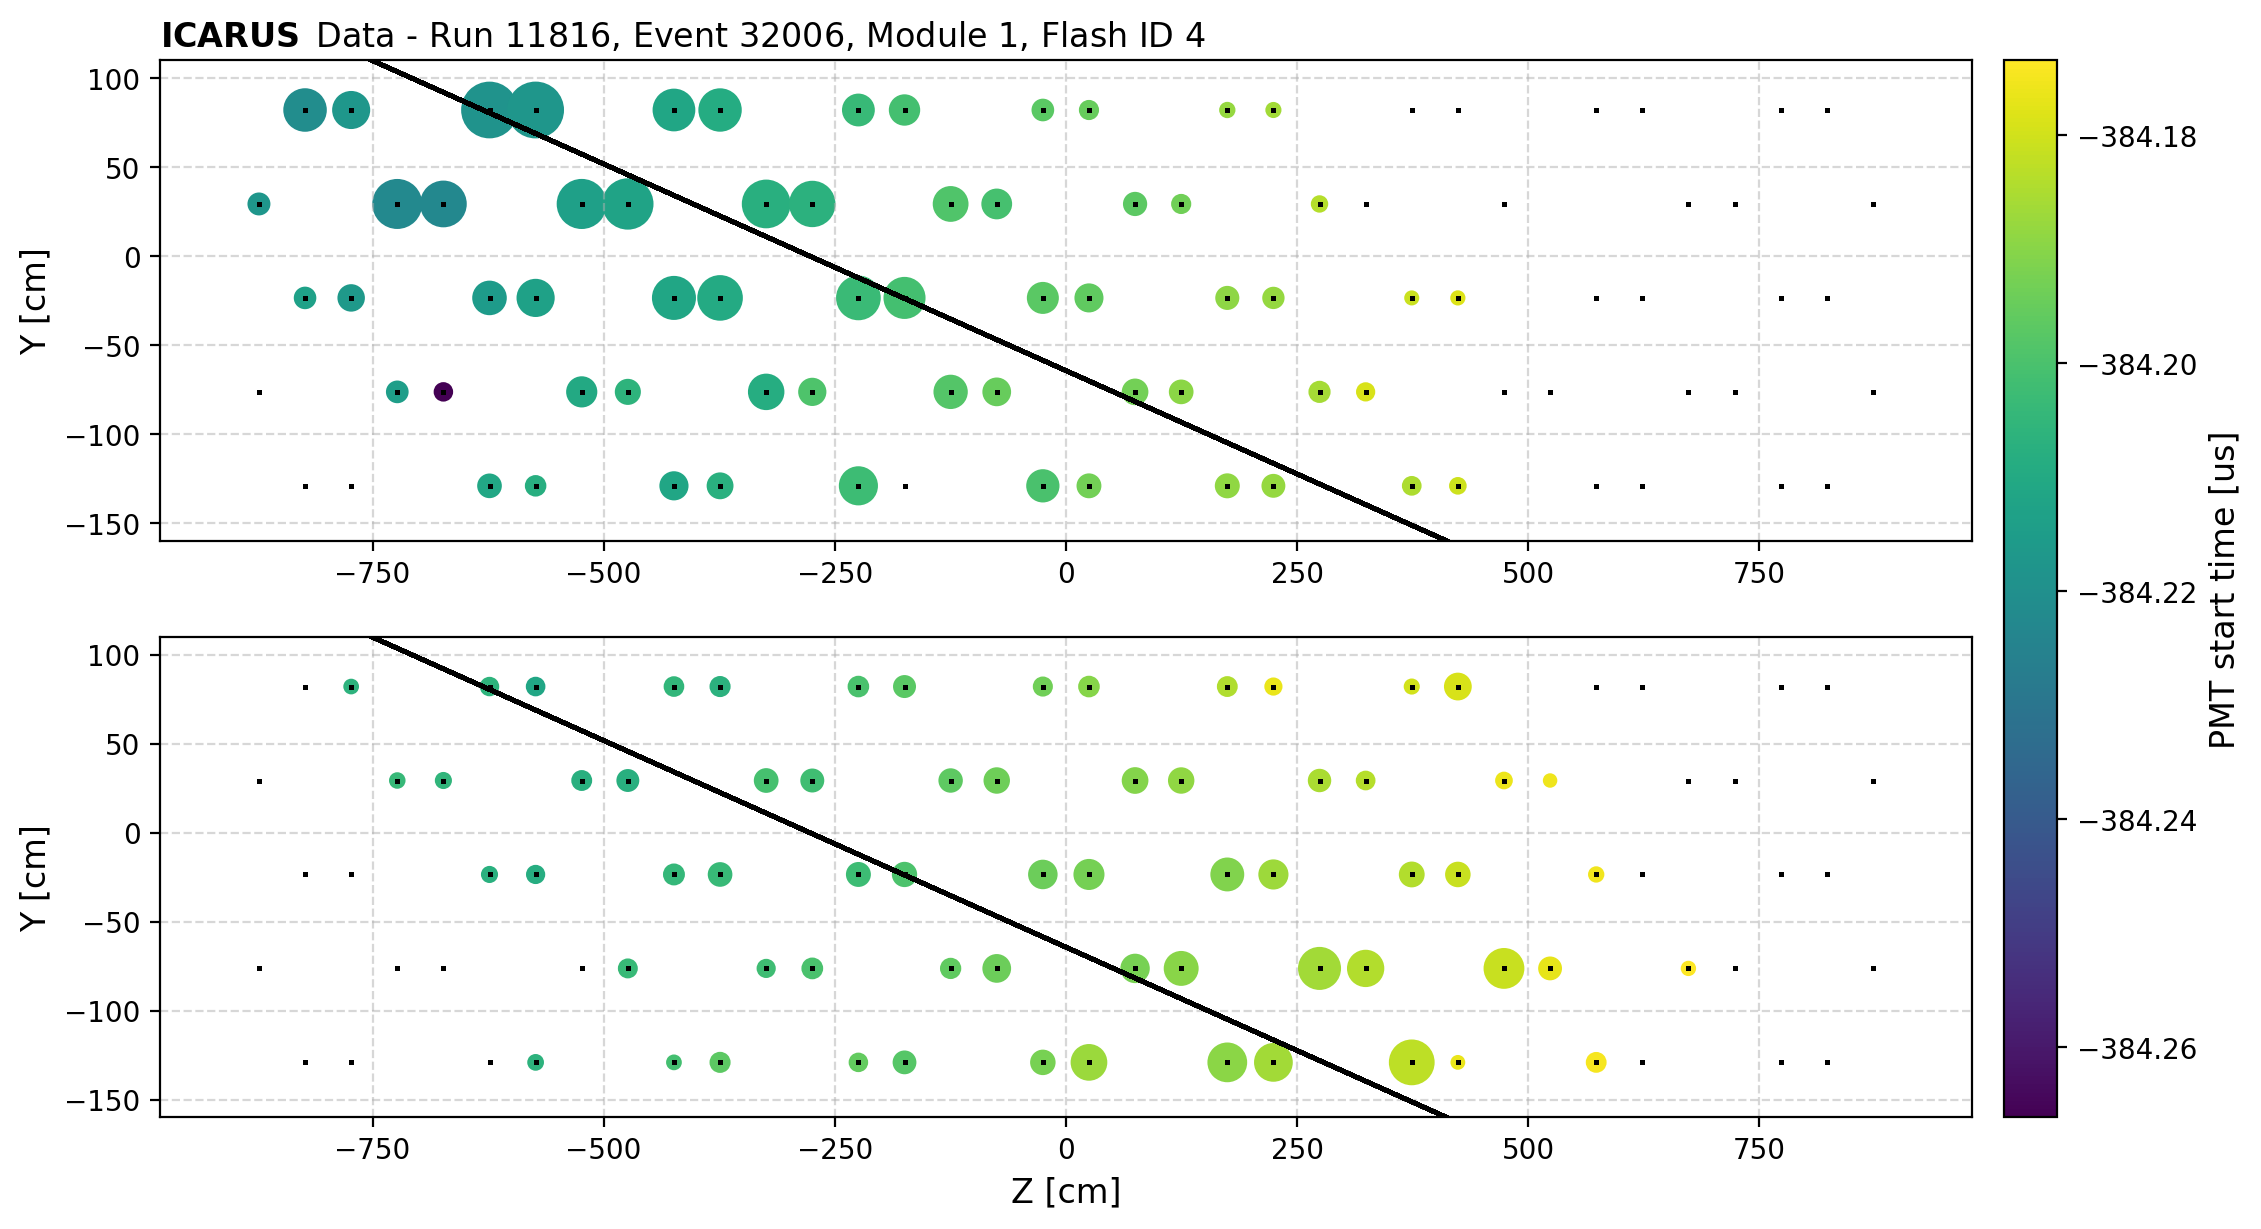

In [59]:
# Here we make the plots 
fig, ax = plt.subplots(2,1, figsize=(14, 7), dpi=200 )

tmin = evtdf[evtdf.pmt_pe>50]["pmt_time"].min()
tmax = evtdf[evtdf.pmt_pe>50]["pmt_time"].max()

zpos = df[df.tpc==0].pmt_z.to_numpy()
ypos = df[df.tpc==0].pmt_y.to_numpy()

for i in np.unique(df.tpc.to_numpy()):
    
    names = ["EE", "EW", "WE", "WW"]
    name = names[i]
    _stpc=evtdf.tpc==i
    tpc = evtdf[_stpc]
    
    i = i%2 # because we only have 2 axis...
    
    if(len(tpc) == 0 ):
        print("EMPTY " + name )
        continue
            
    # plot the PMTs involved in the flash
    sizes = pd.to_numeric(tpc.pmt_pe, errors='coerce')    
    out1 = ax[i].scatter( x=tpc.pmt_z, y = tpc.pmt_y, s=sizes*0.35, c= tpc.pmt_time, cmap='viridis',
                          vmin=tmin, vmax=tmax)
    
    # plot all the PMTs in the wall
    ax[i].scatter(x=zpos,y=ypos,s=0.5,c="black",marker="o")
    
    # plot the track projection on the wall
    ax[i].plot( [evtdf.track_start_z, evtdf.track_end_z], [evtdf.track_start_y, evtdf.track_end_y], color='black' )
    
for i in range(2):
    ax[i].set_ylabel("Y [cm]", fontsize=12)
    if i!=0:
        ax[i].set_xlabel("Z [cm]", fontsize=12)
    ax[i].set_xlim( (-980, 980) )
    ax[i].set_ylim( (-160, 110) )
    ax[i].grid(alpha=0.5, linestyle="dashed") 
    
# plot common colorbar!
cbar = fig.colorbar(out1, ax=ax, orientation='vertical', pad=0.015)
cbar.set_label(label="PMT start time [us]", size=12)

# add a watermark!
watermark = r'$\mathbf{ICARUS}\,$ Data' +' - Run {}, Event {}, Module {}, Flash ID {}'.format(
            RUN, EVENT, CRYO, FLASH)
ax[0].text(0.0, 1.05, watermark, fontsize=12, color='black', alpha=1,
         ha='left', va='center', transform=ax[0].transAxes)

# save the image as pdf!
savepath = "figs/run{}_event{}_event2d_cryo{}_flash{}.pdf".format(RUN,EVENT,CRYO,FLASH)
print("Saving to {}...".format(savepath))
plt.savefig(savepath,dpi=200)

plt.show()

In [60]:
def _selcryo(xx):
    if xx < 0:
        return 0
    elif xx > 0:
        return 1

def readPlacements(file="/exp/icarus/data/users/mvicenzi/pmt-calibration/input/pmt_positions.csv"):
    geo = pd.read_csv(file,sep=",")
    geo.drop(columns=["entry","subentry"],inplace=True)
    geo["cryo"] = [ _selcryo(val) for val in geo.pmt_x.values ]
    return geo

Saving to figs/run11816_event32006_event3d_cryo1_flash4.pdf...


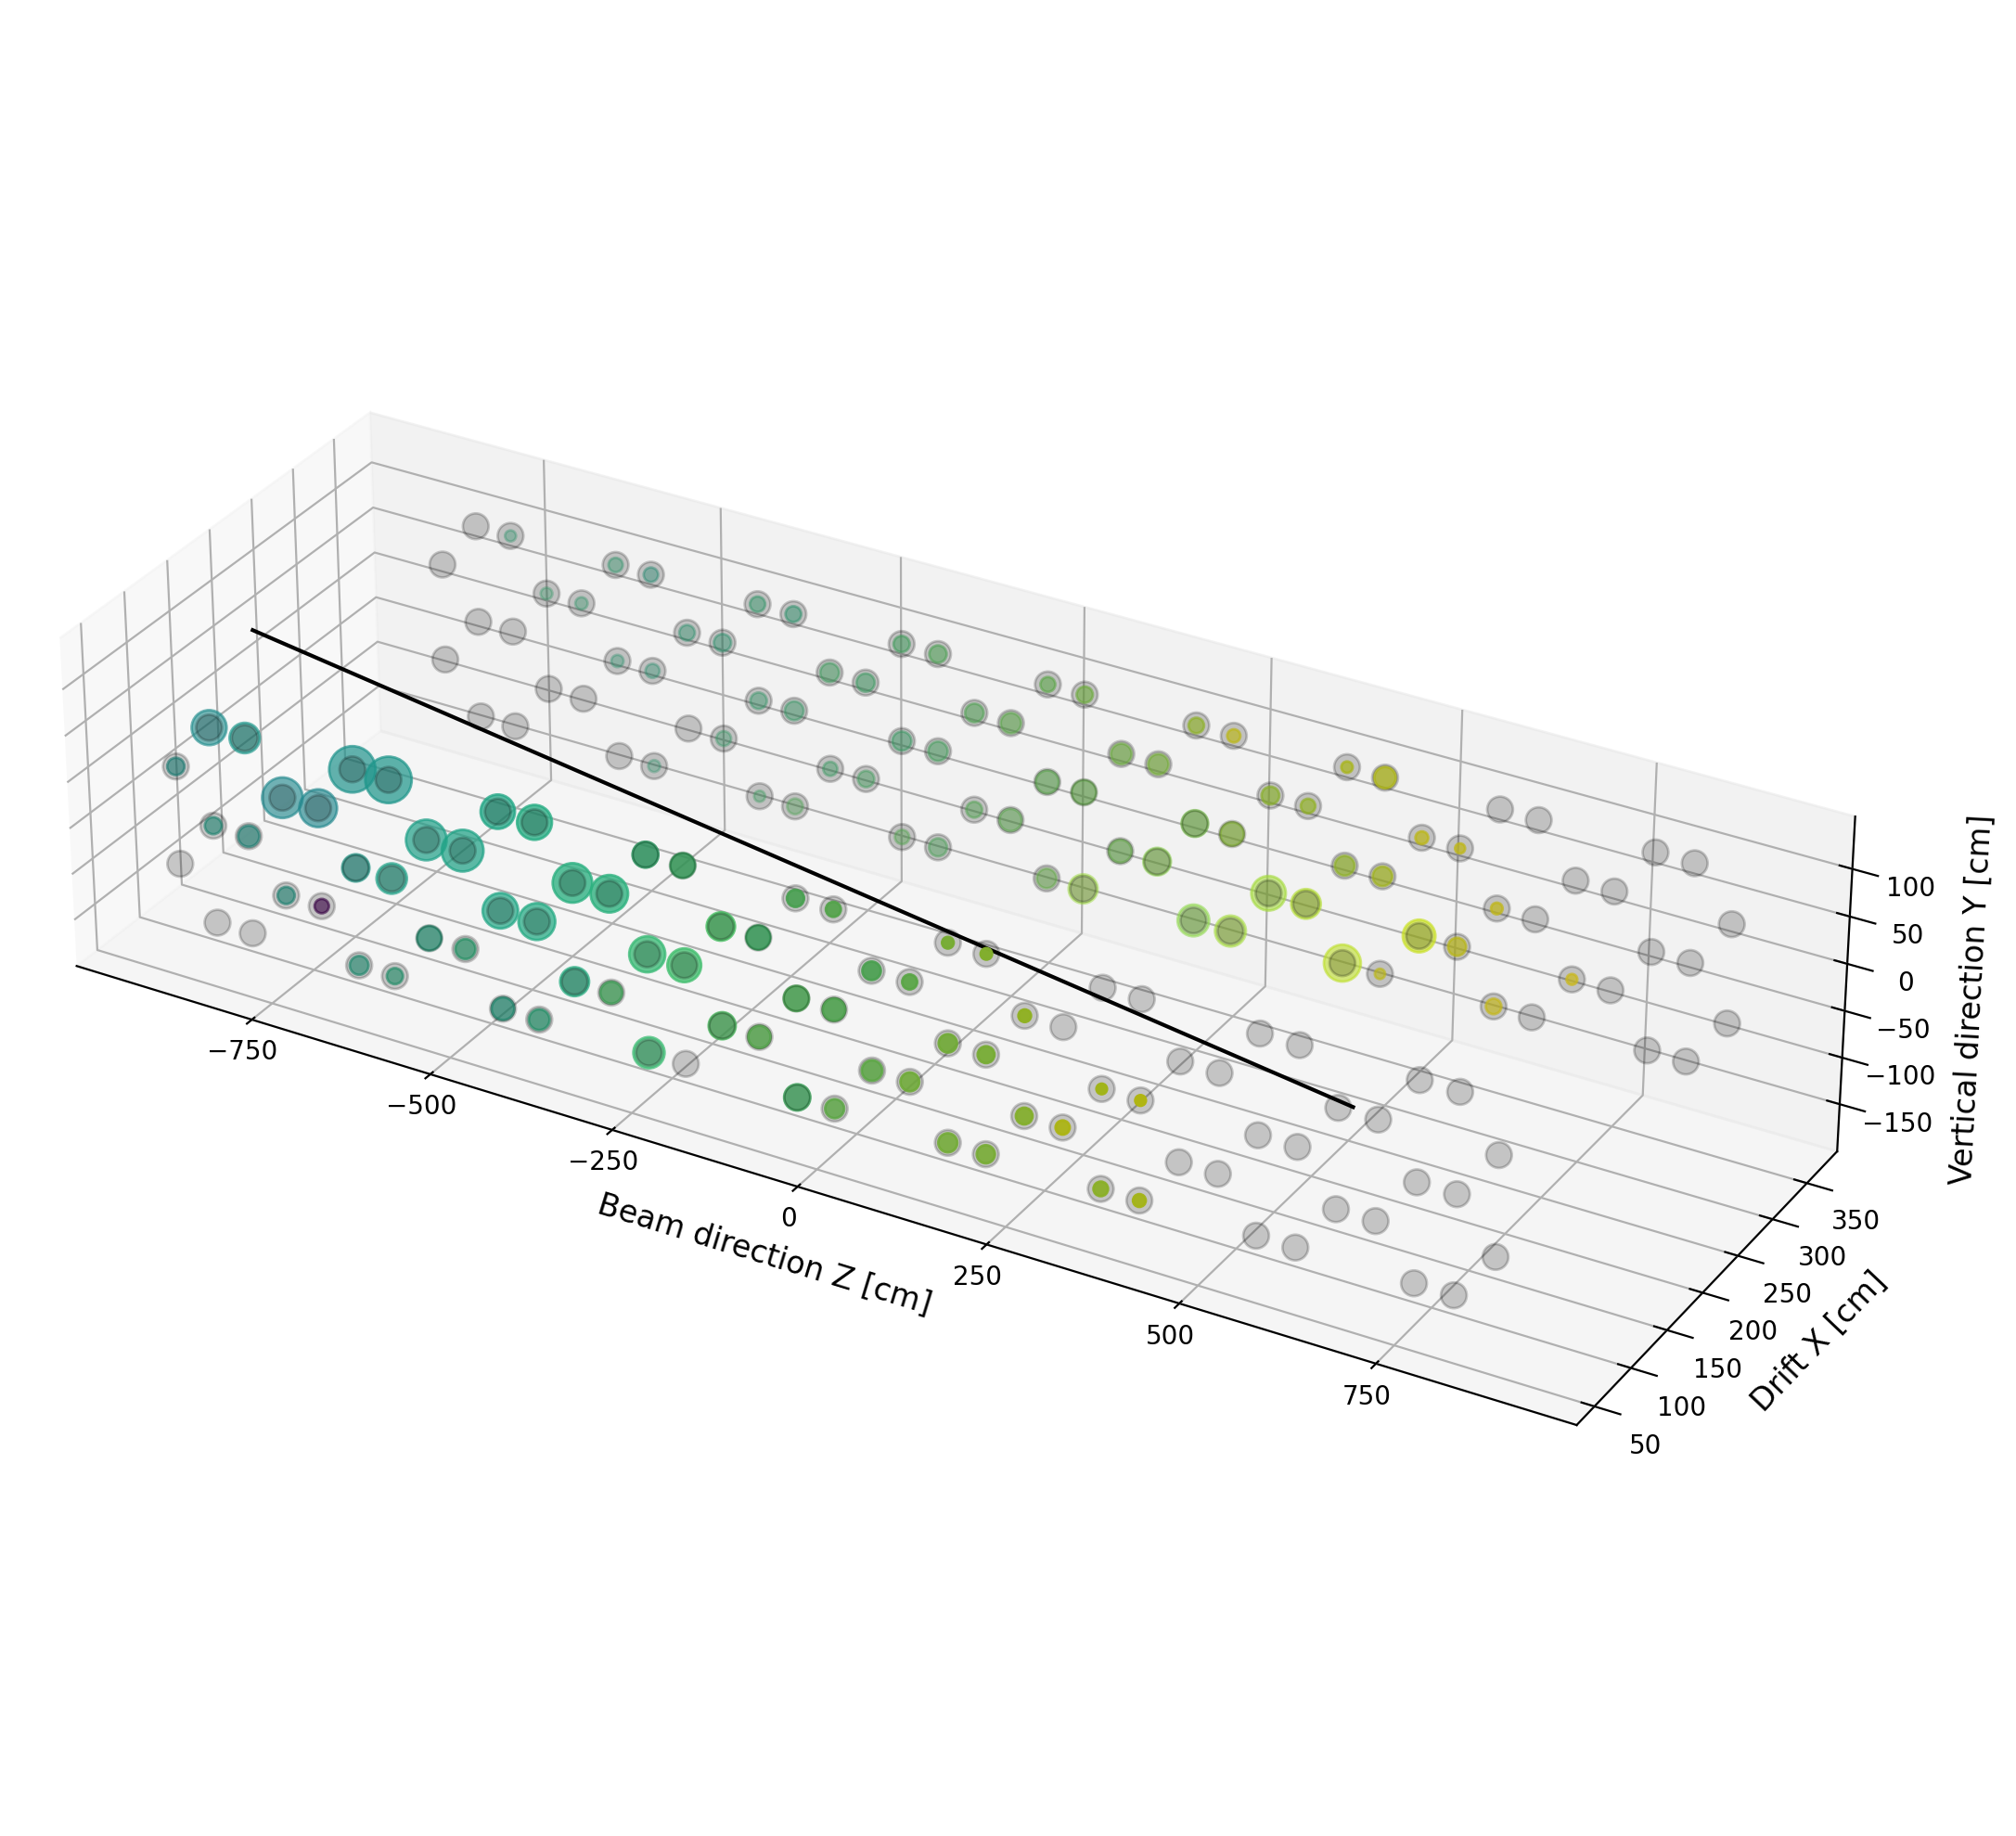

In [61]:
# PLOT in 3D 
fig = plt.figure(figsize=(18, 10), dpi=200)
ax = fig.add_subplot(projection='3d')

# get the 3d positions
geo = readPlacements()
xpos = geo[geo.cryo==CRYO].pmt_x.to_numpy()
ypos = geo[geo.cryo==CRYO].pmt_y.to_numpy()
zpos = geo[geo.cryo==CRYO].pmt_z.to_numpy()

# plot all PMTs in 3D
ax.scatter( zpos, xpos, ypos, c='black', s=100, alpha=0.2  )

# plot PMTs in flash in 3D
sizes = pd.to_numeric(evtdf.pmt_pe, errors='coerce')
out1 = ax.scatter( evtdf.pmt_z, evtdf.pmt_x , evtdf.pmt_y, s=sizes*0.3, c=evtdf.pmt_time, cmap='viridis', vmin=tmin, vmax=tmax ) #YlOrRd
    
# plot 3D track
ax.plot( [evtdf.track_start_z.values[0], evtdf.track_end_z.values[0]], [evtdf.track_start_x.values[0], evtdf.track_end_x.values[0]], [evtdf.track_start_y.values[0], evtdf.track_end_y.values[0]], color='black' )

ax.set_box_aspect(aspect = (9, 3, 2))
ax.set_ylabel("Drift X [cm]", fontsize=12)
ax.set_xlabel("Beam direction Z [cm]",fontsize=12, labelpad=20)
ax.set_zlabel("Vertical direction Y [cm]", fontsize=12)
    
fig.tight_layout()

# save the image as pdf!
savepath = "figs/run{}_event{}_event3d_cryo{}_flash{}.pdf".format(RUN,EVENT,CRYO,FLASH)
print("Saving to {}...".format(savepath))
plt.savefig(savepath,dpi=200)

plt.show()

Saving to figs/run11816_event32006_residuals_cryo1_flash4.pdf...


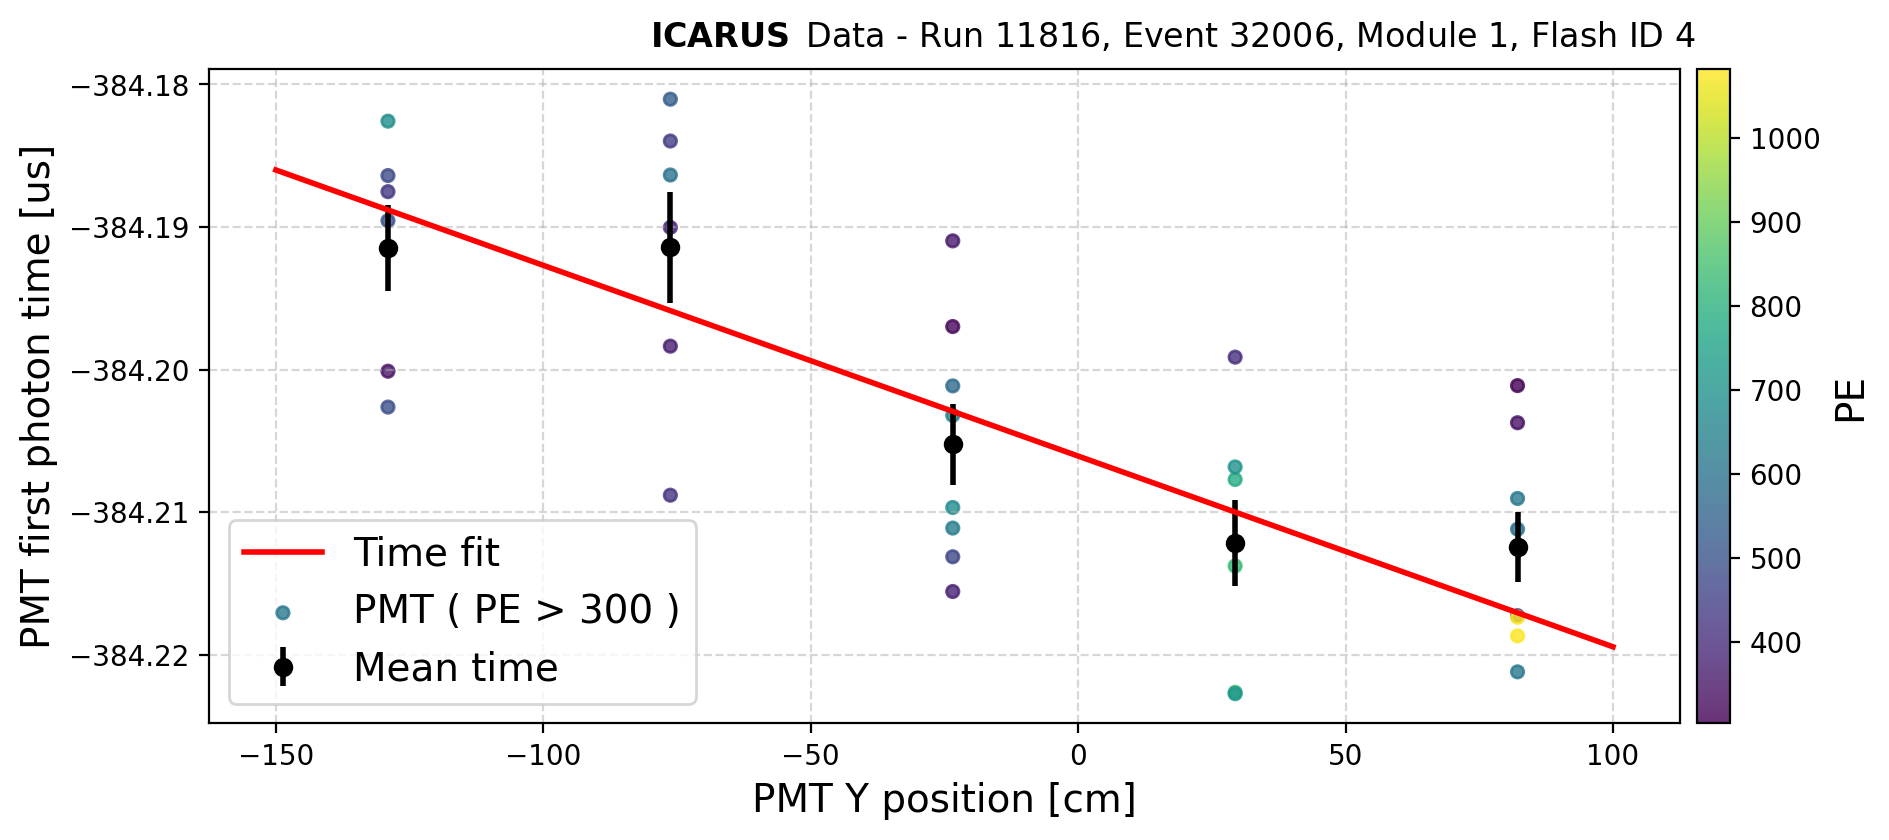

In [62]:
_pecut=300

_sel = evtdf.pmt_pe > _pecut
evtmdf = evtdf[_sel][["pmt_time", "pmt_pe", "pmt_y"]].groupby("pmt_y").apply( 
    lambda x : pd.Series( {
        "mean_time" : np.mean(x.pmt_time),
        "weight_mean_time" : np.average(x.pmt_time, weights=x.pmt_pe), 
        "error_mean_time": np.std(x.pmt_time) / np.sqrt(len(x.pmt_time))
    }) ).reset_index()

fig, ax = plt.subplots( 1,1, figsize=(10, 4.3), dpi=200)

out = ax.scatter( evtdf[_sel].pmt_y, evtdf[_sel].pmt_time, c=evtdf[_sel].pmt_pe, s=20, label='PMT ( PE > {} )'.format(_pecut), cmap='viridis', alpha=0.8 ) #jet
cbar = fig.colorbar( out, ax=ax, pad=0.01 )
cbar.set_label(label="PE", size=14)

#ax.errorbar( x=evtmdf.pmt_y, y=evtmdf.weight_mean_time, yerr=evtmdf.error_mean_time, marker='o', elinewidth=2.0, lw=0, label='Weighted mean time', color='grey' )
ax.errorbar( x=evtmdf.pmt_y, y=evtmdf.mean_time, yerr=evtmdf.error_mean_time, marker='o', elinewidth=2.0, lw=0, label='Mean time', color='black' )

res = stats.linregress( evtmdf.pmt_y, evtmdf.weight_mean_time ) 
ax.plot( np.linspace(-150, 100),  np.linspace(-150, 100)*res.slope+res.intercept, lw=2.0, color='red', label='Time fit' )

#ax.scatter(chy,chtime,color="magenta",marker="x")
#plt.ylim(-367.64,-367.62)

ax.set_ylabel("PMT first photon time [us]", fontsize=14)
ax.set_xlabel("PMT Y position [cm]", fontsize=14)
ax.grid(alpha=0.5, linestyle='dashed')
ax.legend()
ax.legend(loc='lower left',fontsize=14)

watermark = r'$\mathbf{ICARUS}\,$ Data' +' - Run {}, Event {}, Module {}, Flash ID {}'.format(
            RUN, EVENT, CRYO, FLASH)
ax.text(0.30, 1.05, watermark, fontsize=12, color='black', alpha=1,
         ha='left', va='center', transform=ax.transAxes)

fig.tight_layout()

savepath = "figs/run{}_event{}_residuals_cryo{}_flash{}.pdf".format(RUN,EVENT,CRYO,FLASH)
print("Saving to {}...".format(savepath))
plt.savefig(savepath,dpi=200)

plt.show()

In [50]:
evtmdf.head()

,pmt_y,mean_time,weight_mean_time,error_mean_time
0,-129.050003,-59.484511,-59.484534,0.000191
1,-23.450001,-59.485120,-59.485120,0.000000
2,82.150002,-59.488286,-59.488286,0.000000
